# Bag of Words EDA

In [136]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The data isn't a nicely formatted CSV file, so at this point I'll have to 'read the manual' to figure out how to load it. 

### Read the manual

>Data Set Characteristics: Text
...
Attribute Characteristics: Integer
...
Associated Tasks: Clustering
Missing Values? N/A

The data is text data, there is also numeric (integer) data, clustering is a suggested approach, and there are no missing data.

>D is the number of documents, W is the
number of words in the vocabulary, and N is the total number of words
in the collection 

For each dataset, there is acount of the number of documents, there is a count of the number of discrete words, and there is a count of the total number of words. 

>After tokenization and removal of stopwords, the
vocabulary of unique words was truncated by only keeping words that
occurred more than ten times

The words were tokenised, which explains the integer data. Stopwords were removed, so some noise has already been removed from the dataset. Only words that were used 10+ times in a datset will be counted within the documents of that dataset, which again removes noise that can't be usefully learnt from (if a word is only used once in one document, how can a model learn usefully from that for predicting other documents?)

>These data sets have no class labels, and for copyright reasons no
filenames or other document-level metadata.  These data sets are ideal
for clustering and topic modeling experiments.

There are no class labels, so there will be no supervised learning. Clustering is suggested again. 

>For each text collection we provide docword.*.txt (the bag of words
file in sparse format) and vocab.*.txt (the vocab file).

The data comes in two separate files. One has the counts, and one has the actual words. 

>Enron Emails:  
orig source: www.cs.cmu.edu/~enron  
D=39861  
W=28102  
N=6,400,000 (approx)

There are ~40,000 data samples, ~28,000 features (discrete words), and ~6,400,000 words in total. Given the possible amount of data is 93861\*28192=1,120,173,822, and 6400000/1120173822=0.57%, which makes this a _very_ sparse dataset. 

>(below, NNZ is the number of nonzero counts in the
bag-of-words)  

>The format of the docword.*.txt file is 3 header lines, followed by NNZ triples:  
---  
D  
W  
NNZ  
docID wordID count

I should remove the first three lines of the file when reading it in, and add them manually as column headers. 

>The format of the vocab.*.txt file is line contains wordID=n.

Assuming n is line number, then that explains the key between docword files and vocab files. It doesn't tell me if that count starts from zero or one, so I'll have to check if zeros appear in the docword data once loaded. 

So, the data is awkwardly arranged and very sparse. 

In [2]:
# Data loading
docword_column_names = ['docID', 'wordID', 'count']
docword_data = pd.read_csv('../input/docword.enron.txt', delim_whitespace=True, header=None, skiprows=3, names=docword_column_names)
vocab_column_names = ['word']
vocab_data = pd.read_csv('../input/vocab.enron.txt', delim_whitespace=True, header=None, names=vocab_column_names)

In [3]:
# Lets take a look at random samples of the datasets. For the sake of presentation each will be in it's own cell. 
docword_data.sample(5, random_state=4)

,docID,wordID,count
463546,6215,16538,1
1513672,22251,26042,1
2183547,28113,12037,1
423124,5811,24206,1
3214446,33983,5007,1


The data appears to be as described, integer numerical data, with docID and wordID being nominal categorical data, and count being discrete ratio data. 

In [4]:
vocab_data.sample(5, random_state=4)

,word
24695,tahomaarial
24097,street
15783,mexicos
14723,longrun
8018,eliminating


Again, this all appears to be as described, and is obviously nominal categorical data. 

In [5]:
# Descriptive statistics
docword_data.describe()

,docID,wordID,count
count,3.710420e+06,3.710420e+06,3.710420e+06
mean,2.268149e+04,1.393388e+04,1.728153e+00
std,1.094254e+04,8.020984e+03,2.565260e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.403200e+04,6.808000e+03,1.000000e+00
50%,2.557000e+04,1.415600e+04,1.000000e+00
75%,3.168300e+04,2.083500e+04,2.000000e+00
max,3.986100e+04,2.810200e+04,4.030000e+02


While not the easiest to read, the above statistical description does confirm that the wordID does not start from zero, there are 39861 documents and 28102 discrete words. Also interesting to note, is that while the minimum number of times a word appears in a document is one, and the mean is 1.728, and the 75% is two, the max is 403, which is (relatively) a huge number. 

In [6]:
vocab_data.describe()

,word
count,28101
unique,28101
top,mis
freq,1


Of limited use, this at least confirms that there are 28102 discrete words (shown as 28101 because it started counting from zero).  
That means there'll be an off-by-one error for all the references between the two data structures.  

###### Note 
It should be noted that the data in this dataset, while it will be treated as if it's features are independent, doesn't not actually have independent variables. The occurence of one word is dependent on the occurence or lack of occurent of other words preceeding it in a sentence. 

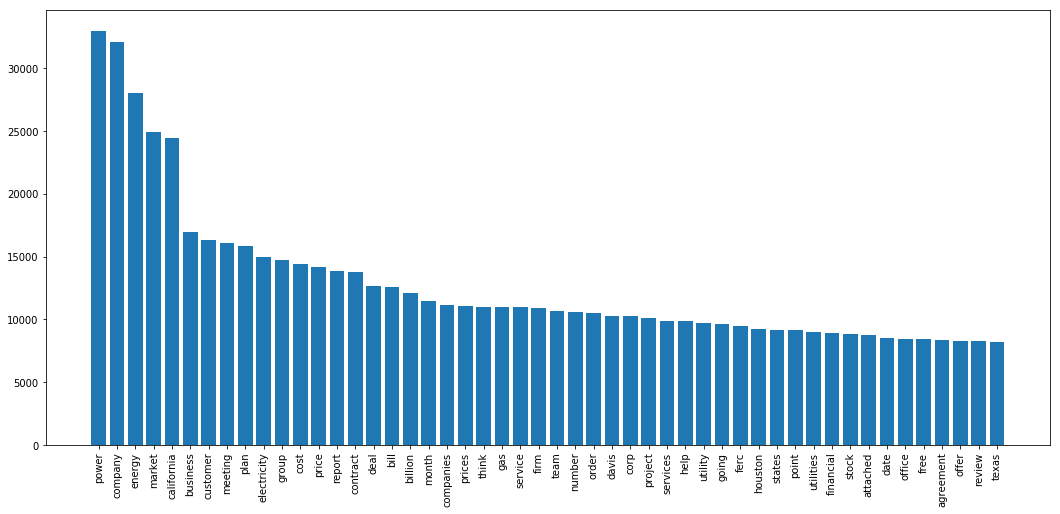

In [196]:
sorted_counts = docword_data[['wordID', 'count']].groupby('wordID').sum().sort_values('count', ascending=False)
high_word_counts =  sorted_counts[0:50]

f = lambda x: x-1
high_word_indexes = high_word_counts.index.tolist()
high_word_indexes[:] = [x - 1 for x in high_word_indexes]
most_common_words = vocab_data.iloc[high_word_indexes]['word'].values.tolist()
most_common_word_counts = high_word_counts.iloc[0:50,:]['count'].values.tolist()

fig_1, ax_1 = plt.subplots(figsize=(18,8))
ax_1.bar(most_common_words, most_common_word_counts)
plt.xticks(rotation='vertical');

The most common words occur thousands of times more than any word after them, and even then the most common two words occur as many times more than the fifth most common word, as that word does the sixth.  
The 21 top words are all nouns, or can be used as nouns. The 22nd word; 'think', is the most common word that isn't a noun. 

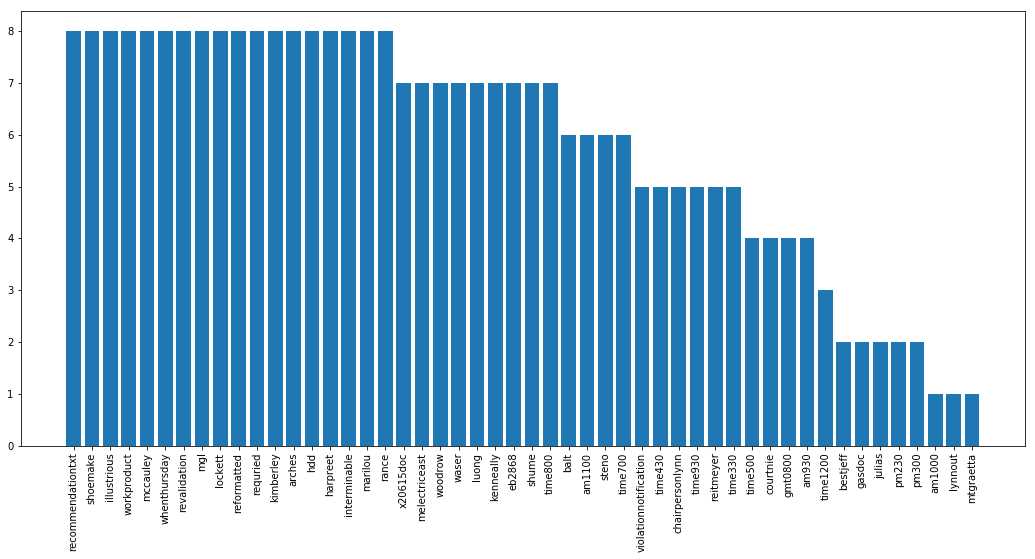

In [202]:
low_word_counts =  sorted_counts[-50:]

f = lambda x: x-1
low_word_indexes = low_word_counts.index.tolist()
low_word_indexes[:] = [x - 1 for x in low_word_indexes]
least_common_words = vocab_data.iloc[low_word_indexes]['word'].values.tolist()
least_common_word_counts = low_word_counts.iloc[0:50,:]['count'].values.tolist()

fig_2, ax_2 = plt.subplots(figsize=(18,8))
ax_2.bar(least_common_words, least_common_word_counts)
plt.xticks(rotation='vertical');

There are three words that occur only once in the entire dataset; 'am1000', 'lynnout', 'mtgraetta'. A lot of the least comon words look like misspellings and typos. 

The most and least common words are interesting to look at, but don't actually tell me very much.  
What would be interesting, would be to look at: 
1. The length of emails (number of words per document)
2. Look for outlier emails based on what words occur in them (if there is enough consistency in the content of emails for outliers to make up a minority of the documents)
3. If the least common words end up in the same clusters? 
4. If the least common words end up in the same emails? 